# Requirements

- Python3.5-3.8
- Tesnorflow (`pip install tensorflow`)
- Tensorflow Dataset (`pip install tensorflow_datasets`)
- Requsets (`pip install requests`)
- Easytensor (`pip install easytensor`)
- Matplotlib (`pip install matplotlib`)

In [152]:
! pip install tensorflow tensorflow_datasets requests easytensor matplotlib

     |████████████████████████████████| 8.5 MB 1.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 3.3 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 346 kB/s eta 0:00:01


# Train a simple MNIST model
Here, we will train a simple model that can classify english digits from 1 to 9. The MNIST dataset is made up of small images that are 28x28 pixels.

The full explanation of how this model is trained can be found [here](https://www.tensorflow.org/datasets/keras_example).

In [126]:
import tensorflow as tf
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


In [127]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [128]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [129]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
)

Epoch 1/6
469/469 [==============================] - 3s 3ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.1966 - val_sparse_categorical_accuracy: 0.9434
Epoch 2/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1811 - sparse_categorical_accuracy: 0.9487 - val_loss: 0.1393 - val_sparse_categorical_accuracy: 0.9596
Epoch 3/6
469/469 [==============================] - 1s 2ms/step - loss: 0.1239 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1164 - val_sparse_categorical_accuracy: 0.9657
Epoch 4/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0898 - sparse_categorical_accuracy: 0.9732 - val_loss: 0.0936 - val_sparse_categorical_accuracy: 0.9718
Epoch 5/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0768 - sparse_categorical_accuracy: 0.9785 - val_loss: 0.0835 - val_sparse_categorical_accuracy: 0.9750
Epoch 6/6
469/469 [==============================] - 1s 2ms/step - loss: 0.0600 - sparse_categorical_accu

In [130]:
import os
export_path = os.path.join(os.getcwd(), "my_model")
print("export_path: {}".format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

export_path: /Users/kamalkamalaldin/repos/python-client/my_model
INFO:tensorflow:Assets written to: /Users/kamalkamalaldin/repos/python-client/my_model/assets


INFO:tensorflow:Assets written to: /Users/kamalkamalaldin/repos/python-client/my_model/assets


# Upload to EasyTensor
Now that we have the model exported, we can upload it to cloud and have EasyTensor serve it for us!

In [132]:
import easytensor
model_id, access_token = easytensor.upload_model("Showing dana Model", export_path)

That's it! The model is now in the cloud with one line of code. Each model will have an ID and an access token. Anyone with the access token can send requests to the model, so make sure you store it somewhere safe!

In [133]:
print("model ID:", model_id)
print("access token:", access_token)

model ID: d38e2b13-b22c-4556-9509-2418fdc6a118
access token: e3525e19-2ec9-4a1b-9fa1-48d35e3a2ba7


# Use the model
Now let's try to use the model via a simple http request. We will use a random image from the training set.

In [226]:
# We need to get the label and image in the same iterator to get around shuffling.
image_label_tuples = list(map(lambda x: (x[0], x[1]), ds_train)) 
image_batches = list(map(lambda x: x[0], image_label_tuples)) # shape (x, 128, 28, 28, 1)
label_batches = list(map(lambda x: x[1], image_label_tuples)) # shape (x, 128, 1)
print("number of image batches:", len(image_batches))
print("Each batch contains", image_batches[0].shape[0], "images")
print("Each image has shape", image_batches[0][0].shape)

number of image batches: 469
Each batch contains 128 images
Each image has shape (28, 28, 1)


Image to send:


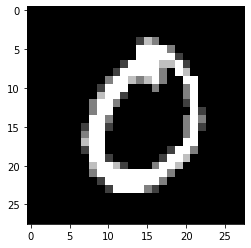

In [232]:
import matplotlib.pyplot as plt
fig = plt.figure
plt.imshow(image_batches[0][0], cmap='gray')
print("Image to send:")
plt.show()

image_to_predict = image_batches[0][0]

In [233]:
from pprint import pprint
response = requests.post(
    "https://app.easytensor.com/query/",
    json={
        "instances": [
            # use the first picture of the first batch
            # make it a serializable list
            image_to_predict.numpy().tolist()
        ]
    },
    headers={"accessToken": access_token}
)
print("Response from server:")
pprint(response.json())
print("Digit prediction: ", np.array(response.json()["predictions"]).argmax(axis=1))

Response from server:
{'predictions': [[10.6536636,
                  -5.54453468,
                  -2.0866,
                  -2.84490108,
                  -8.73831654,
                  -1.36901224,
                  -0.546078086,
                  -2.26826048,
                  -3.7583766,
                  -4.20979548]]}
Digit prediction:  [0]


## Batch processing
If we want, we can send multiple data samples for prediction. This is especially useful for batch processing workloads that might be running in the background.

In [235]:
response = requests.post(
        "https://app.easytensor.com/query/",
        json={
            "instances": [
                # use the entireity of first batch
                # make it a serializable list
                image_batches[0].numpy().tolist()
            ]
        },
        headers={"accessToken": access_token}
    )
predictions = np.array(response.json()["predictions"])
correct = 0
for prediction, label in zip(
    predictions.argmax(axis=1), label_batches[0]
):
    if prediction == label.numpy():
        correct += 1
print("{} Images were classified".format(len(predictions)))
print("Accuracy:", correct/len(predictions))

128 Images were classified
Accuracy: 0.96875
